# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys
from pytz import timezone
import pathlib

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K
from tqdm.keras import TqdmCallback
from tensorflow.keras import optimizers

RESULT_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/seq2seq_pm25_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(RESULT_DIR).mkdir(parents=True, exist_ok=True)
print(RESULT_DIR)

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction, plot_learning_curves
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice
from src.time_series_utils import splitTrainValidationTestTimeSeries, reframePastFuture, padPastFuture

# Checking Tensorflow
print(f"Tensorflow version: {tf.__version__}, GPUs: {tf.config.list_physical_devices('GPU')}")

E0000 00:00:1764827405.384847   41464 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764827405.391349   41464 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764827405.408101   41464 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764827405.408132   41464 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764827405.408133   41464 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764827405.408135   41464 computation_placer.cc:177] computation placer already registered. Please check linka

/le_thanh_van_118/workspace/hiep_workspace/seq2seq_pm25_results/2025_12_04-12_50_07
Using GPU to train
Tensorflow version: 2.19.1, GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# DATA FROM VIET

## Load dataset

In [3]:
dataset_path = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"

df_raw = []

for csv_file in sorted(glob.glob(f"{dataset_path}/*")):
    print(f"Working on {csv_file}")
    df_station = pd.read_csv(csv_file)
    df_station["station"] = int(os.path.splitext(os.path.basename(csv_file))[0])
    df_raw.append(df_station)
df_raw = pd.concat(df_raw, axis=0)

# Set time index
df_raw["date"] = pd.to_datetime(df_raw["date"])
df_raw.set_index("date", inplace=True)

# Drop columns
#features_to_use = ["pm25_quantrac", "tsp_quantrac", "station"]
#features_to_use = ["PM25_quantrac", "TSP_quantrac", "O3_quantrac", "CO_quantrac", "NO2_quantrac", "Temperature_quantrac", "Humid_quantrac", "station"]
features_to_use = ["PM25_quantrac", "TSP_quantrac", "station"]
df_raw = df_raw.loc[:, features_to_use]

df_raw

Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/211.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/212.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/213.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/214.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/215.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station/216.csv


PM25_quantrac  TSP_quantrac  station
date                                                     
2021-02-23 21:00:00      15.604762     32.935714      211
2021-02-23 22:00:00      14.594118     30.932353      211
2021-02-23 23:00:00      13.436667     27.645000      211
2021-02-24 00:00:00      12.365000     24.380000      211
2021-02-24 01:00:00      11.636667     22.521667      211
...                            ...           ...      ...
2022-12-31 19:00:00      41.450000    107.451667      216
2022-12-31 20:00:00      50.530000    126.168333      216
2022-12-31 21:00:00      55.055000    139.688333      216
2022-12-31 22:00:00      26.078333     63.565000      216
2022-12-31 23:00:00      21.161667     51.705000      216

[92966 rows x 3 columns]

## Data preparation

### Drop missing

In [4]:
df = []
for station in sorted(df_raw["station"].unique()):
    df_station = df_raw[df_raw["station"] == station]
    df.append(df_station.dropna())
df = pd.concat(df, axis=0)
df

PM25_quantrac  TSP_quantrac  station
date                                                     
2021-02-23 21:00:00      15.604762     32.935714      211
2021-02-23 22:00:00      14.594118     30.932353      211
2021-02-23 23:00:00      13.436667     27.645000      211
2021-02-24 00:00:00      12.365000     24.380000      211
2021-02-24 01:00:00      11.636667     22.521667      211
...                            ...           ...      ...
2022-12-31 19:00:00      41.450000    107.451667      216
2022-12-31 20:00:00      50.530000    126.168333      216
2022-12-31 21:00:00      55.055000    139.688333      216
2022-12-31 22:00:00      26.078333     63.565000      216
2022-12-31 23:00:00      21.161667     51.705000      216

[49923 rows x 3 columns]

### Scale

In [5]:
df_scaled = copy.deepcopy(df)

# Scale label
label = "PM25_quantrac"
label_scaler = MinMaxScaler()
df_scaled[label] = label_scaler.fit_transform(df[[label]])

# Scale features
features_to_scale = features_to_use
features_to_scale.remove(label)
for f in features_to_scale:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[f]])
    df_scaled[f] = scaled_data

# Drop station column
df_scaled = df_scaled.drop(columns=["station"], errors="ignore")

df_scaled

PM25_quantrac  TSP_quantrac
date                                            
2021-02-23 21:00:00       0.096032      0.091311
2021-02-23 22:00:00       0.089813      0.085757
2021-02-23 23:00:00       0.082690      0.076643
2021-02-24 00:00:00       0.076095      0.067591
2021-02-24 01:00:00       0.071612      0.062439
...                            ...           ...
2022-12-31 19:00:00       0.255085      0.297899
2022-12-31 20:00:00       0.310963      0.349789
2022-12-31 21:00:00       0.338810      0.387272
2022-12-31 22:00:00       0.160487      0.176228
2022-12-31 23:00:00       0.130230      0.143347

[49923 rows x 2 columns]

### Train test split

In [6]:
splitter = round(0.8 * len(df_scaled))
train_data = df_scaled.iloc[:splitter]
test_data = df_scaled.iloc[splitter:]

display(train_data)
display(test_data)

PM25_quantrac  TSP_quantrac
date                                            
2021-02-23 21:00:00       0.096032      0.091311
2021-02-23 22:00:00       0.089813      0.085757
2021-02-23 23:00:00       0.082690      0.076643
2021-02-24 00:00:00       0.076095      0.067591
2021-02-24 01:00:00       0.071612      0.062439
...                            ...           ...
2021-09-21 06:00:00       0.059110      0.052214
2021-09-21 07:00:00       0.065058      0.058590
2021-09-21 08:00:00       0.067930      0.060540
2021-09-21 09:00:00       0.062597      0.054857
2021-09-21 10:00:00       0.061017      0.051631

[39938 rows x 2 columns]

PM25_quantrac  TSP_quantrac
date                                            
2021-09-21 11:00:00       0.065315      0.057731
2021-09-21 12:00:00       0.059551      0.050703
2021-09-21 13:00:00       0.058597      0.048018
2021-09-21 14:00:00       0.053520      0.039493
2021-09-21 15:00:00       0.064546      0.053170
...                            ...           ...
2022-12-31 19:00:00       0.255085      0.297899
2022-12-31 20:00:00       0.310963      0.349789
2022-12-31 21:00:00       0.338810      0.387272
2022-12-31 22:00:00       0.160487      0.176228
2022-12-31 23:00:00       0.130230      0.143347

[9985 rows x 2 columns]

## Prediction

### Model paramaters

In [7]:
n_past = 168

epochs = 100
batch_size = 128

In [8]:
# Calculate MNBE
def mean_normalized_bias_error(y_pred, y_actual):
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    return np.mean((y_pred - y_actual) / np.mean(y_actual)) * 100

metrics_calculators = {
    "mae": mean_absolute_error,
    "mse": mean_squared_error,
    "rmse": root_mean_squared_error,
    "r2": r2_score,
    "mape": mean_absolute_percentage_error,
    "mnbe": mean_normalized_bias_error,
    "r_coeff": lambda a,b: pearsonr(a, b)[0]
}

### Reframe data

In [9]:
# Function to reframe data
def reframe(input_data, n_past, n_future, n_shifted=0):
    data = copy.deepcopy(input_data)
    m = np.arange(0, len(data) - n_past - n_future - n_shifted + 1)
    X = np.array([data.iloc[i:(i + n_past), :] for i in m])
    label_index_col = 0
    y = np.expand_dims(np.array([data.iloc[(i + n_shifted + n_past):(i + n_shifted + n_past + n_future), 0] for i in m]), -1)
    return X, y

X_train_24h, y_train_24h = reframe(train_data, n_past, 24)
X_test_24h, y_test_24h = reframe(test_data, n_past, 24)
print(X_train_24h.shape, y_train_24h.shape, X_test_24h.shape, y_test_24h.shape)

(39747, 168, 2) (39747, 24, 1) (9794, 168, 2) (9794, 24, 1)


### Define callbacks

In [10]:
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True),

### LSTM-Seq2Seq

In [11]:
def define_lstms2s_model(n_past, n_future, n_features, n_label, name="model"):
    inputs = Input(shape=(n_past, n_features))
    lstm_1 = LSTM(128, return_sequences=True, activation="relu")(inputs)
    lstm_2 = LSTM(64, activation="relu", dropout=0.2)(lstm_1)
    dense = Dense(32, activation="relu")(lstm_2)
    outputs = Dense(n_future)(dense)

    # Compile the model
    model = Model(inputs, outputs)
    model.name = name
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError())
    display(model.summary())
    return model

#### 24 hours

I0000 00:00:1764827418.418856   41464 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0


Model: "PM25_quantrac_lstms2s_24h"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 168, 128)       │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,352 (466.22 KB)

 Trainable params: 119,352 (466.22 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/100


I0000 00:00:1764827421.866447   41640 service.cc:152] XLA service 0x71a29800ac10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764827421.866472   41640 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1764827422.560782   41640 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/249 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.1444   

I0000 00:00:1764827439.549051   41640 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 80s 244ms/step - loss: 0.0517 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 187ms/step - loss: 0.0496 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 57s 230ms/step - loss: 0.0484 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 58s 232ms/step - loss: 0.0471 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 58s 231ms/step - loss: 0.0462 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 58s 231ms/step - loss: 0.0454 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - loss: 0.0446 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 57s 230ms/step - loss: 0.0443 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 9/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 57s 230ms/step - loss: 0.0437 - val_loss: 0.0274 - learning

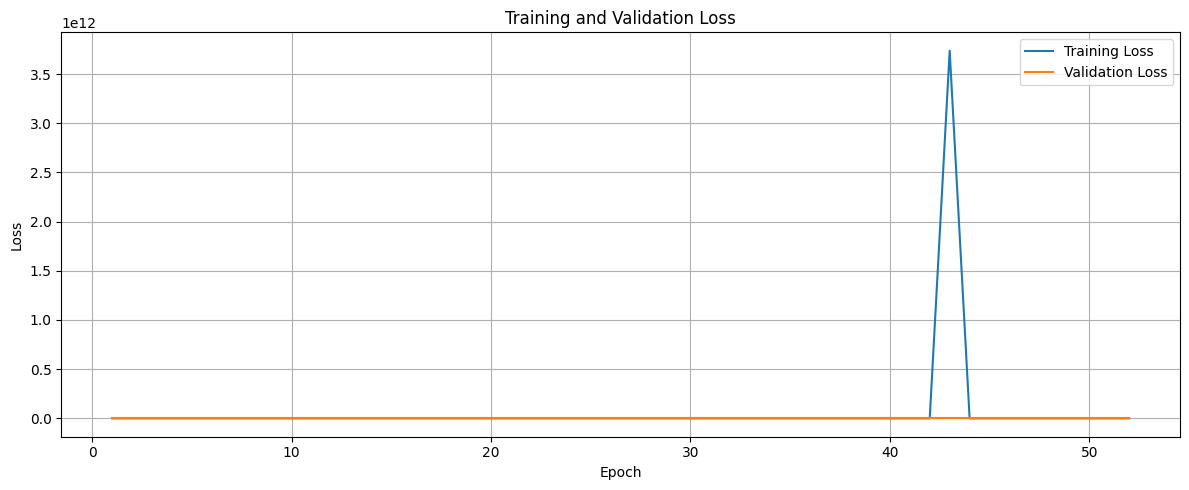

307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
y_pred.shape = (9794, 24)
inv_y_pred.shape = (9794, 24, 1)
inv_y_test.shape = (9794, 24, 1)
Day = 0
mae: 2.2802077242978838
mse: 10.131616505392405
rmse: 3.183020029059259
r2: 0.746206387524619
mape: 0.1213026839786669
mnbe: -9.297825892641766
r_coeff: [0.97276789]


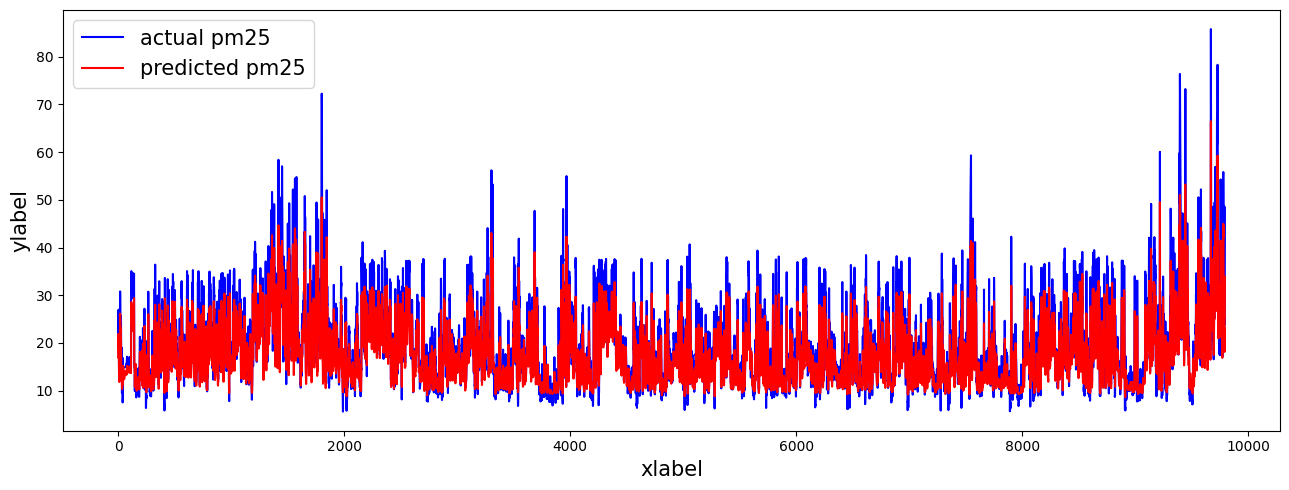

Day = 1
mae: 4.114358100387298
mse: 32.936880909845264
rmse: 5.739066205389625
r2: 0.027362214941974217
mape: 0.2563430561408614
mnbe: -17.51506723613005
r_coeff: [0.8428845]


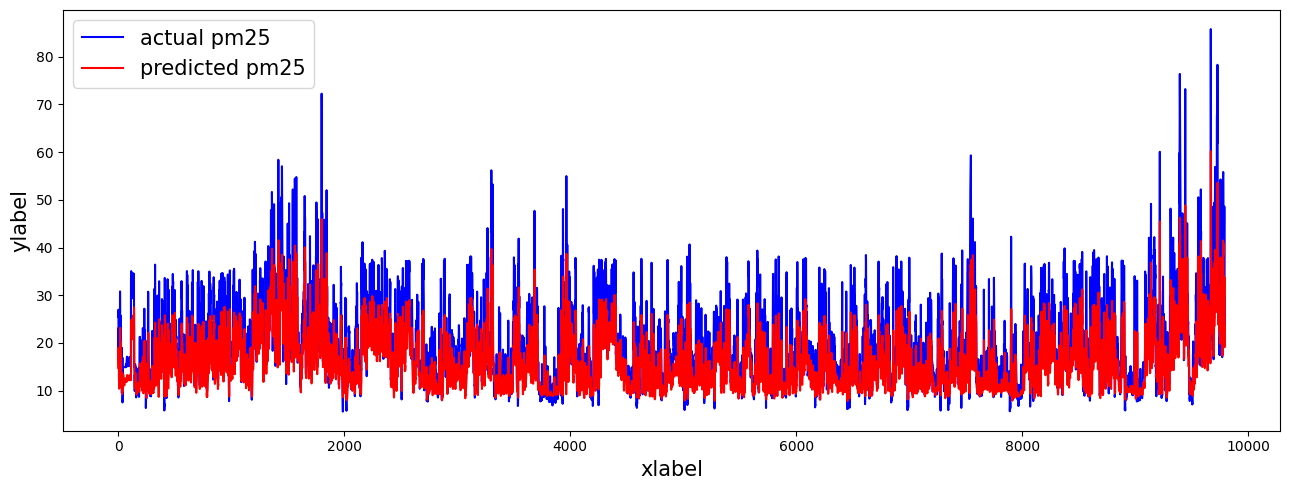

Day = 2
mae: 4.461750927779482
mse: 42.95945027711103
rmse: 6.554345907648682
r2: -0.8724790863119982
mape: 0.26579932133946294
mnbe: -15.122740557151626
r_coeff: [0.7253726]


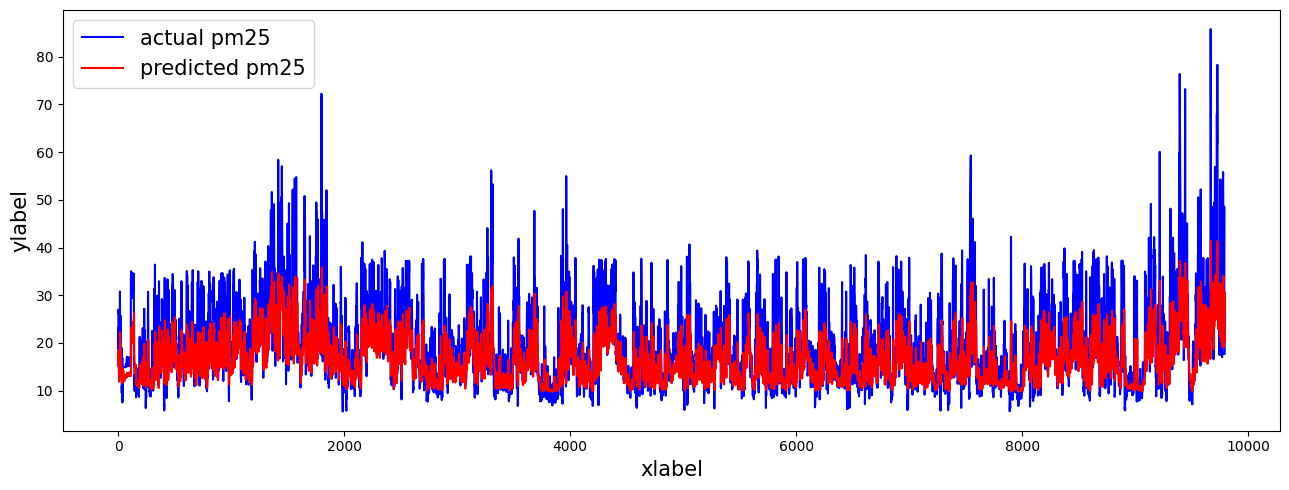

Day = 3
mae: 4.707409061894607
mse: 46.872925272441194
rmse: 6.846380450460024
r2: -0.9298407803548392
mape: 0.2782653466956079
mnbe: -12.56466324763128
r_coeff: [0.64171813]


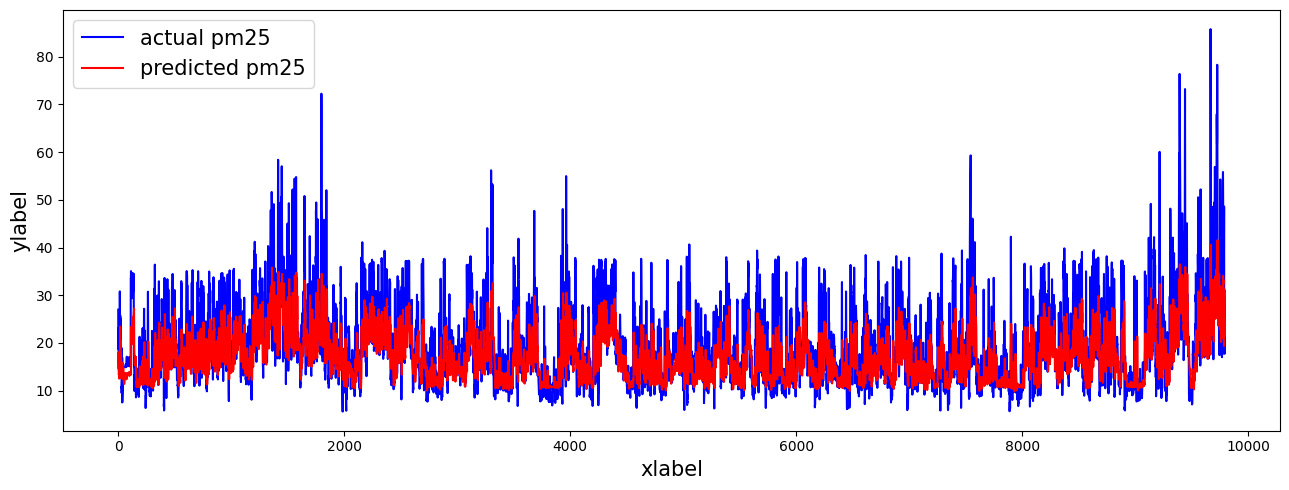

Day = 4
mae: 5.0355144460875305
mse: 54.02057418927576
rmse: 7.349868991300169
r2: -3.206993906189494
mape: 0.2946266571112726
mnbe: -12.810825750855493
r_coeff: [0.57501269]


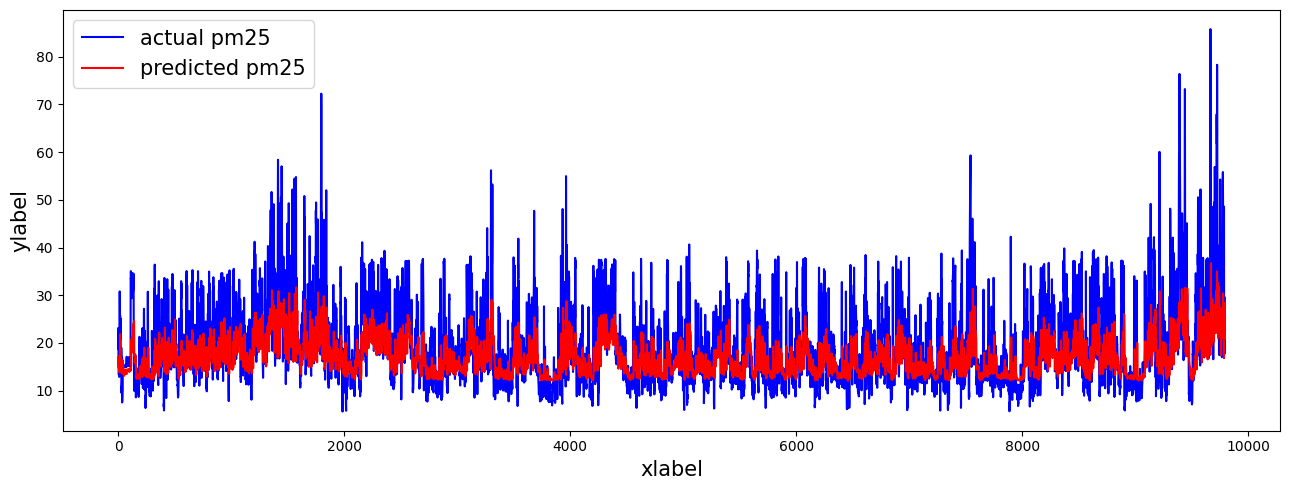

Day = 5
mae: 5.344837727052828
mse: 59.814136292162516
rmse: 7.7339599360329325
r2: -2.2921448615574938
mape: 0.33430630127647587
mnbe: -16.56486391269835
r_coeff: [0.53443166]


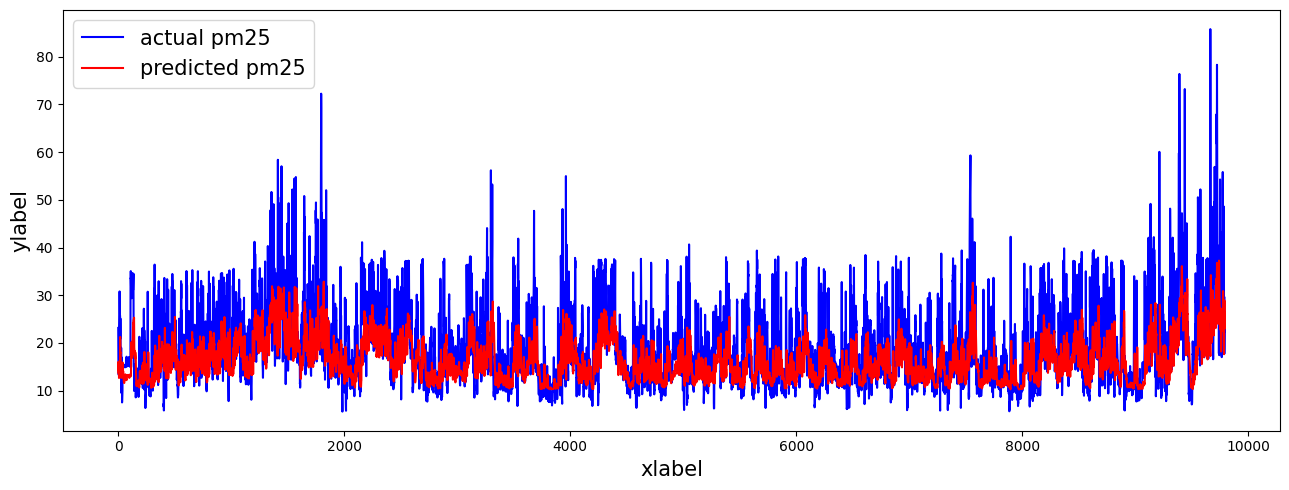

Day = 6
mae: 5.4613457216158805
mse: 62.63256523247442
rmse: 7.914073870799692
r2: -3.374291007720652
mape: 0.340160649580923
mnbe: -16.179403179686844
r_coeff: [0.48881924]


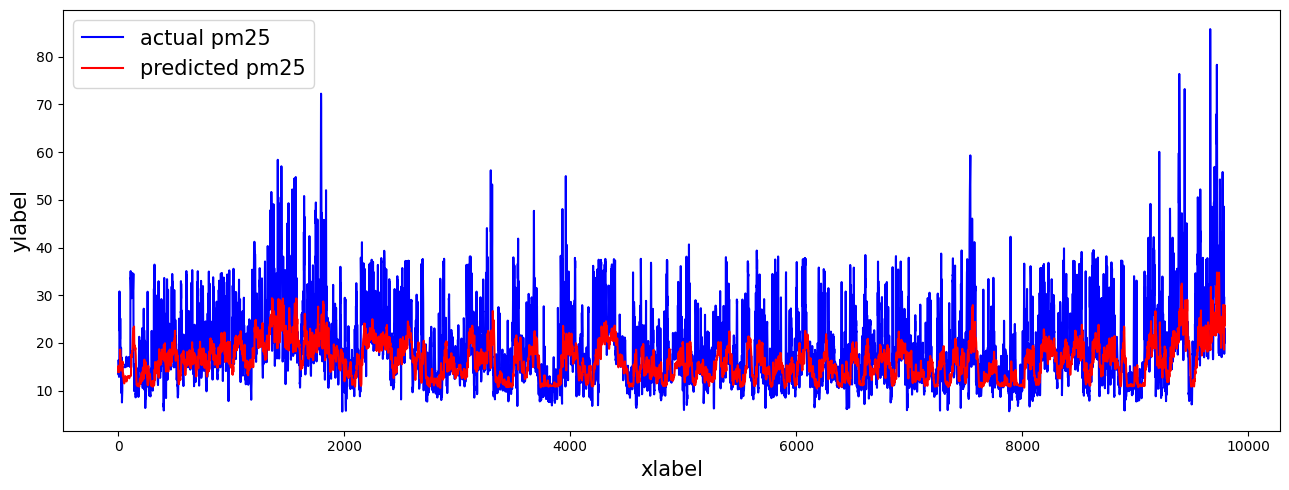

Day = 7
mae: 5.468860988079519
mse: 62.291537576138
rmse: 7.892498816986797
r2: -2.681966406831758
mape: 0.3392083519854427
mnbe: -15.130730495914186
r_coeff: [0.47483237]


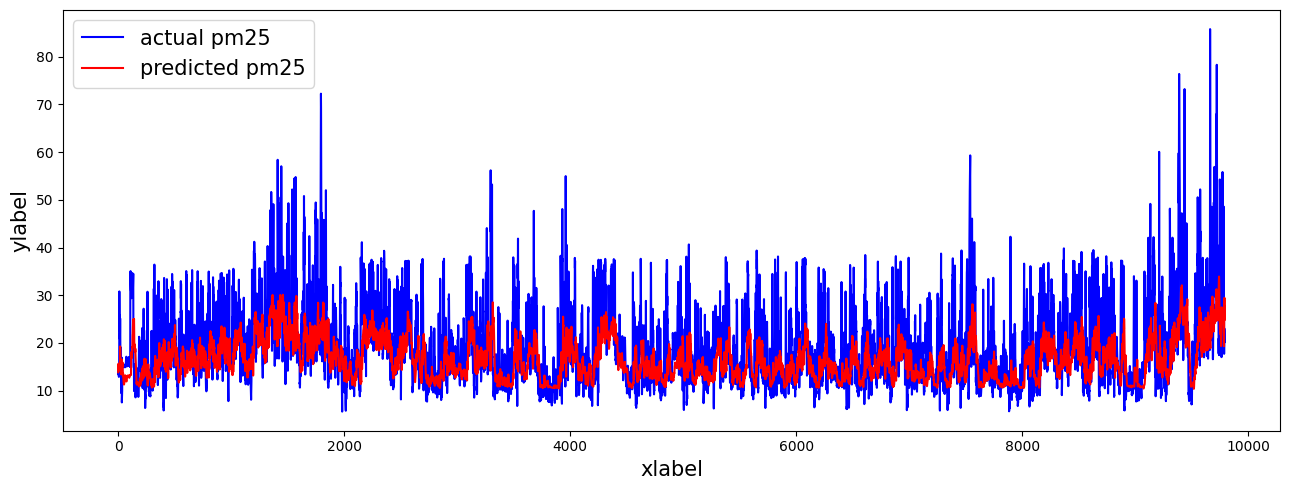

Day = 8
mae: 5.498082922144307
mse: 62.28326191979393
rmse: 7.891974526048214
r2: -2.5076186733508625
mape: 0.3375319348418735
mnbe: -13.814603198924674
r_coeff: [0.45543784]


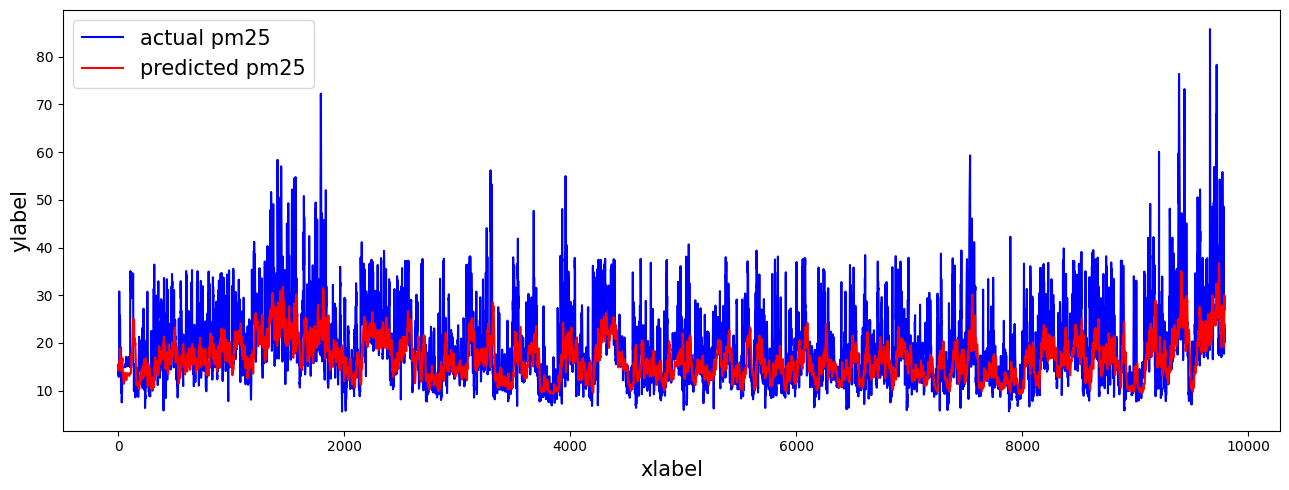

Day = 9
mae: 5.596142517291423
mse: 66.13383394943844
rmse: 8.132271143379224
r2: -6.306767876464139
mape: 0.34577731299108033
mnbe: -16.471300465363758
r_coeff: [0.44703713]


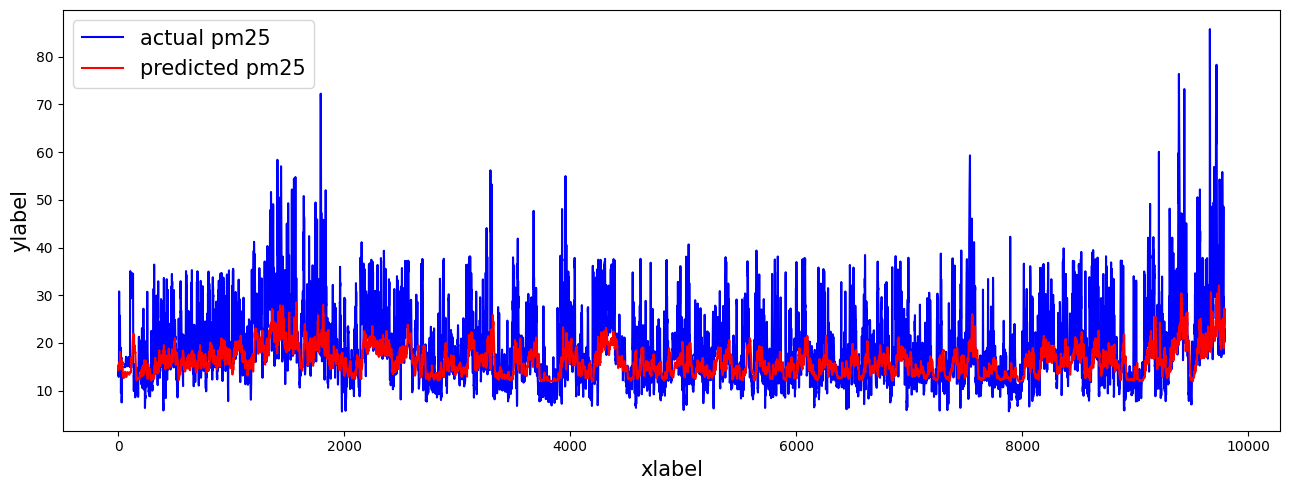

Day = 10
mae: 5.516920516209082
mse: 62.38158593323752
rmse: 7.898201436608053
r2: -2.8716889442218503
mape: 0.3315279719190273
mnbe: -12.344546139231703
r_coeff: [0.43086674]


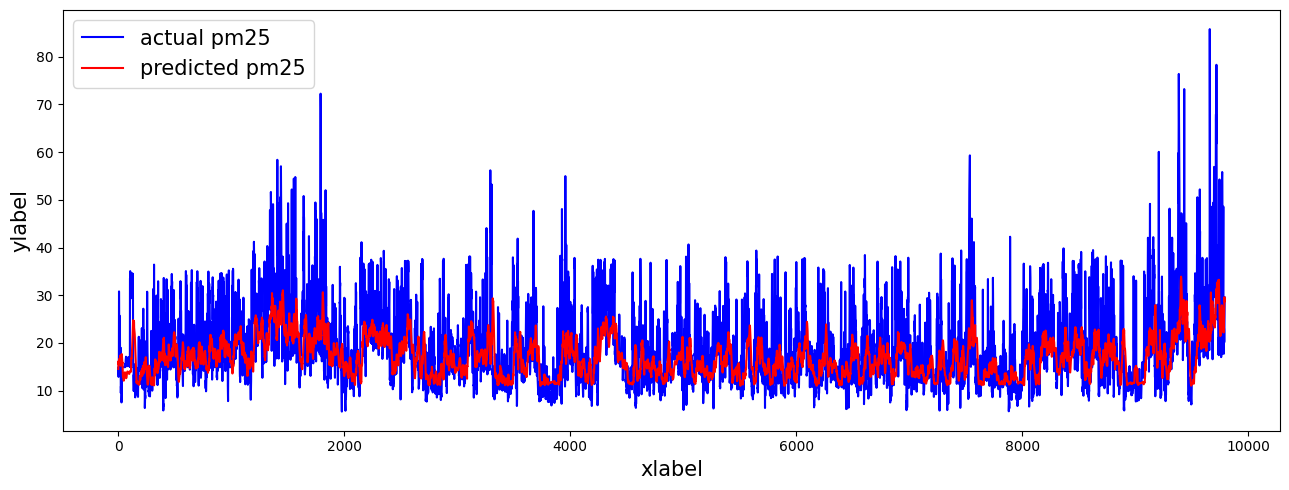

Day = 11
mae: 5.549946073325892
mse: 63.316885934457794
rmse: 7.95719083184875
r2: -3.3611780978073664
mape: 0.3343744756112889
mnbe: -12.862222364804584
r_coeff: [0.42180543]


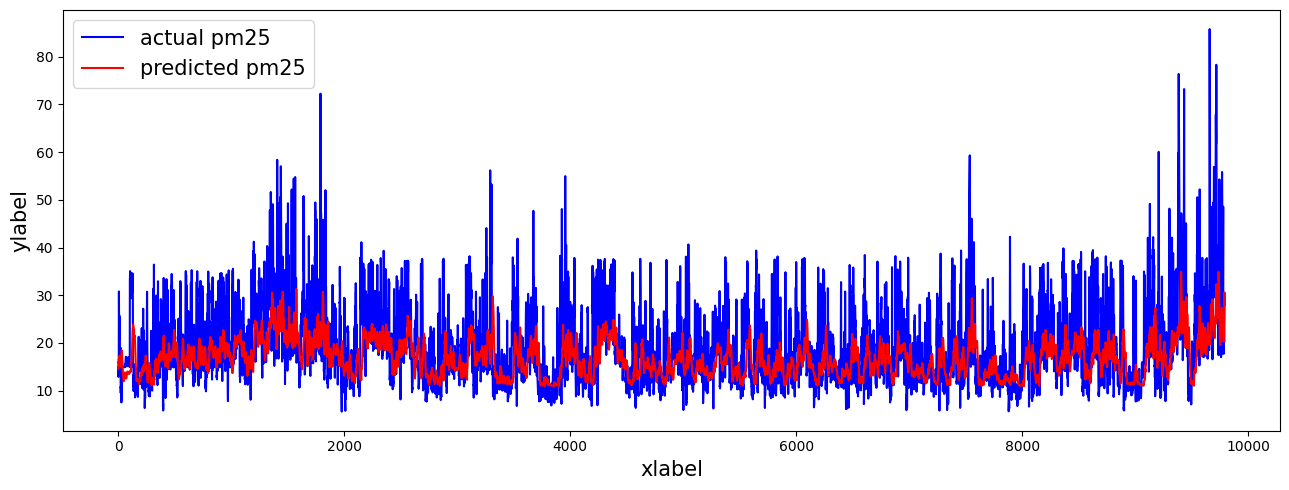

Day = 12
mae: 5.494963819525409
mse: 60.336153185626834
rmse: 7.767634980200012
r2: -2.7803239141910825
mape: 0.3148108104085967
mnbe: -8.670758115416138
r_coeff: [0.41851837]


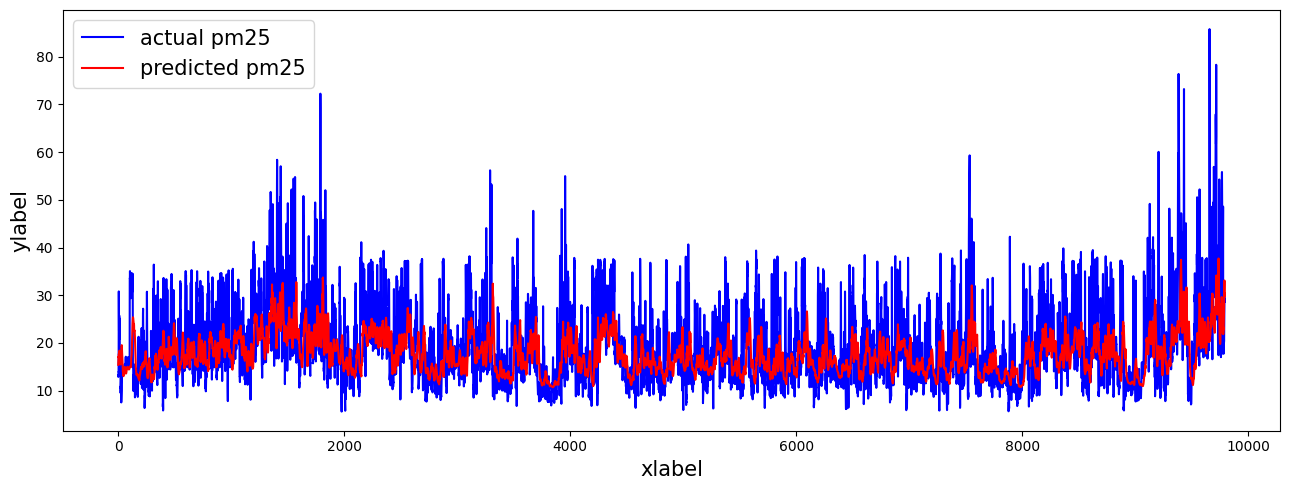

Day = 13
mae: 5.773874970264269
mse: 68.22845910989508
rmse: 8.260052004067232
r2: -2.7632207526564643
mape: 0.3728542284462756
mnbe: -16.728955133262126
r_coeff: [0.41920102]


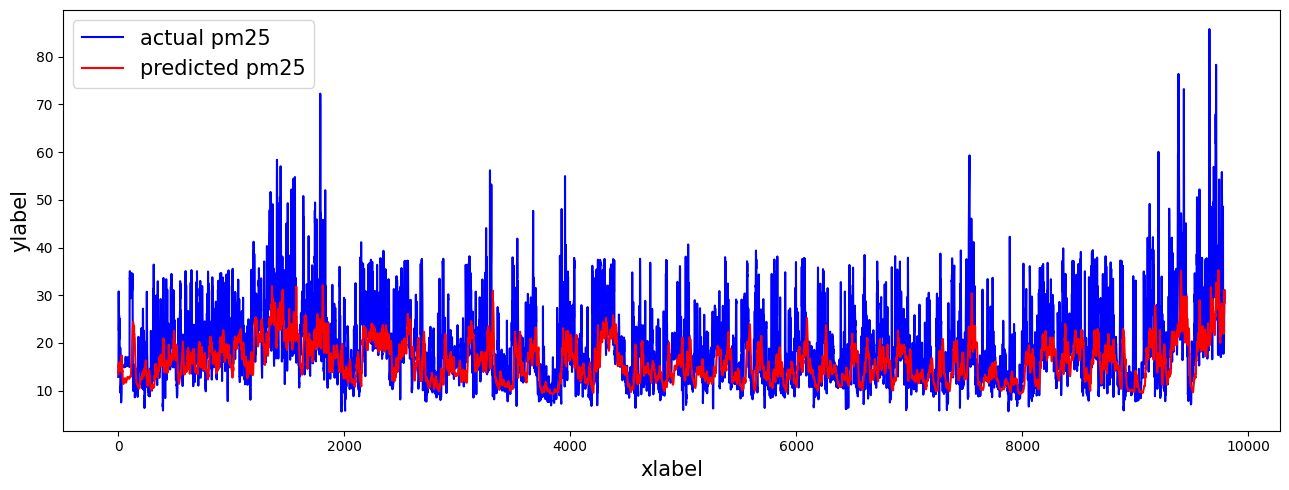

Day = 14
mae: 5.618383966406623
mse: 63.47135902352764
rmse: 7.966891427873712
r2: -2.518955501331677
mape: 0.33810682543371745
mnbe: -11.464158642554178
r_coeff: [0.40837569]


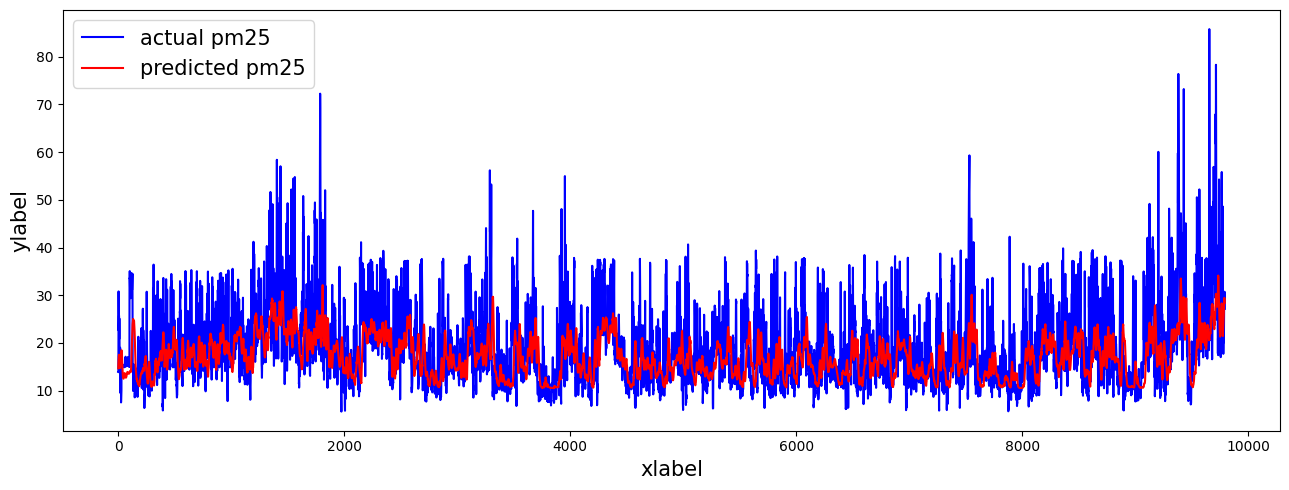

Day = 15
mae: 5.69422169414523
mse: 66.23751508617845
rmse: 8.138643319754125
r2: -3.0156600938640663
mape: 0.3546184785789163
mnbe: -14.777812882375537
r_coeff: [0.41106681]


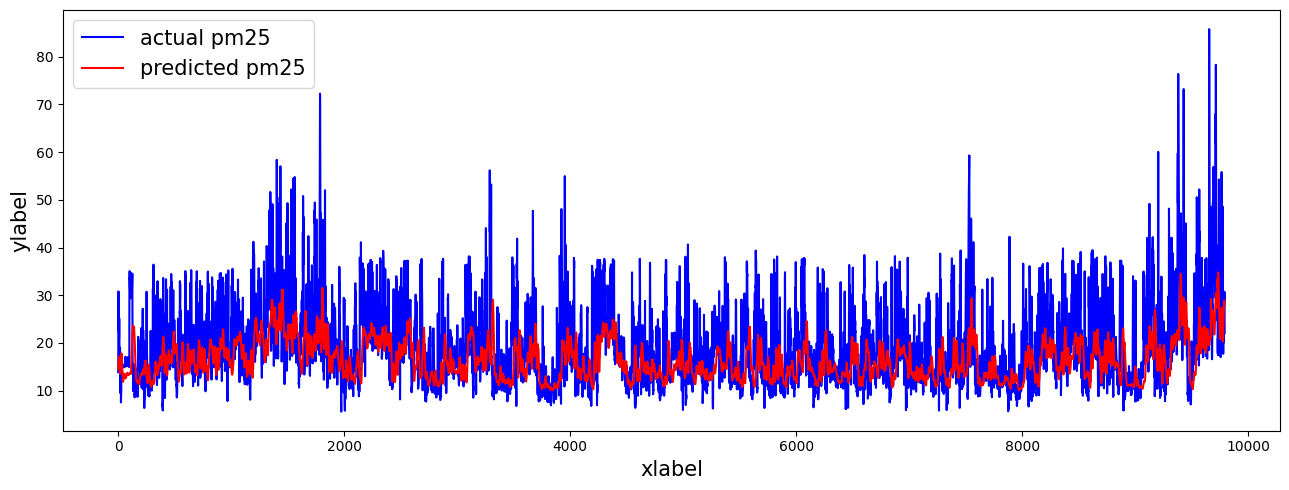

Day = 16
mae: 5.951737665706959
mse: 72.06185831263383
rmse: 8.488925627700706
r2: -3.165284138816097
mape: 0.3973007948830531
mnbe: -18.857880569309344
r_coeff: [0.40254126]


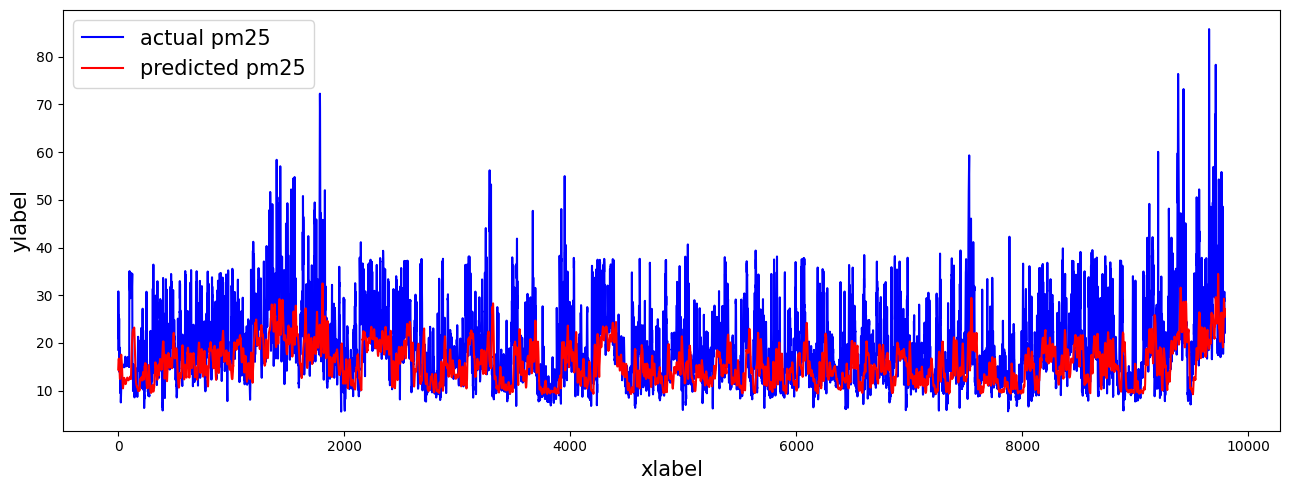

Day = 17
mae: 5.634408021257686
mse: 64.76025787443547
rmse: 8.047375837776901
r2: -5.327983245340284
mape: 0.3353261531570096
mnbe: -12.350337547680535
r_coeff: [0.38648927]


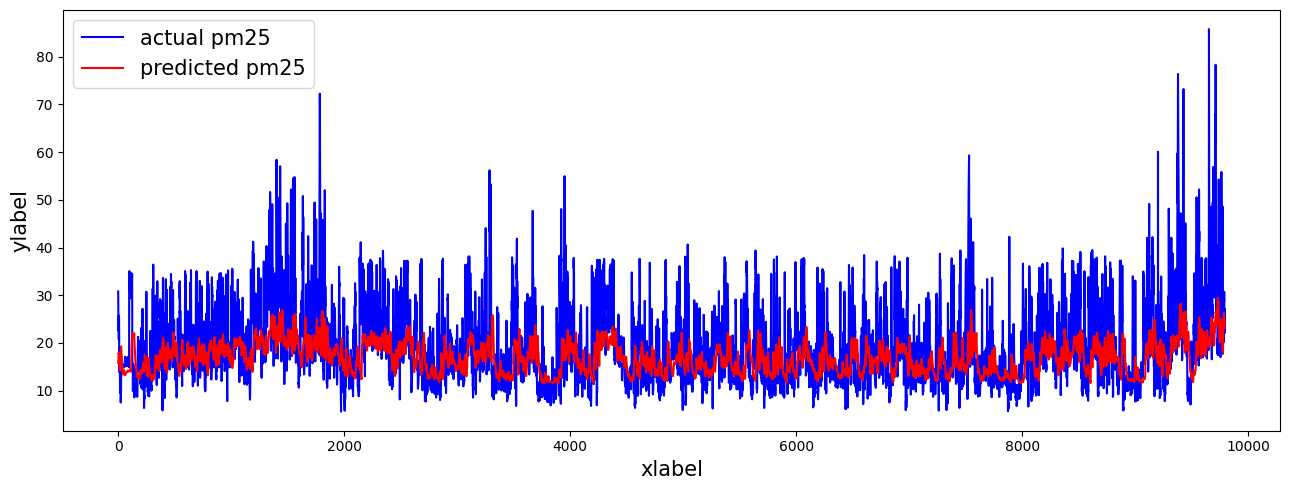

Day = 18
mae: 5.586892538992773
mse: 60.408995276023546
rmse: 7.772322386264195
r2: -2.716114452834173
mape: 0.30998602063370384
mnbe: -5.693069567853661
r_coeff: [0.39476665]


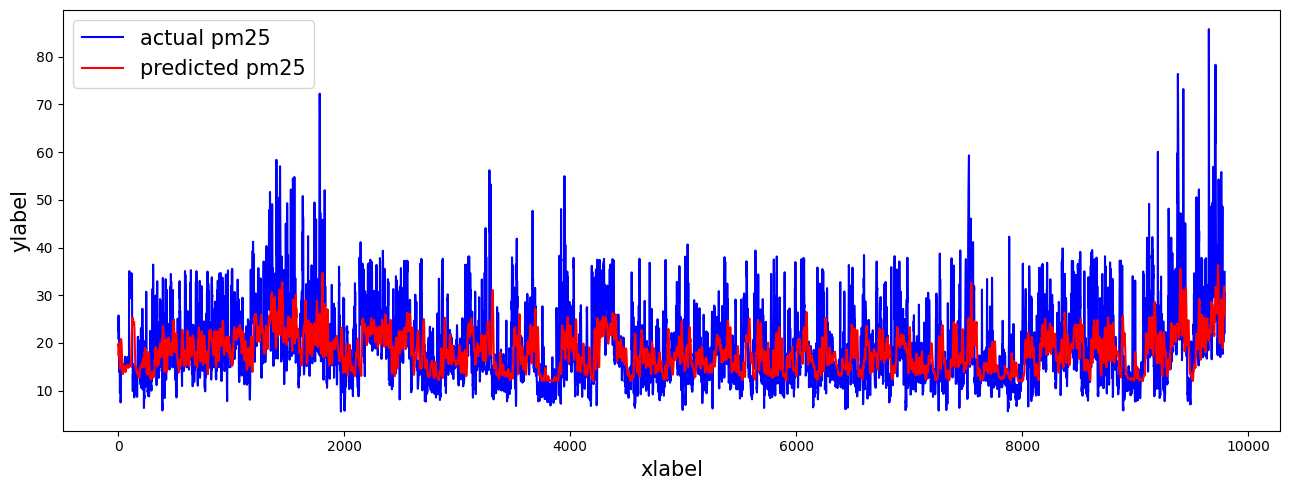

Day = 19
mae: 5.59305067399393
mse: 62.7821799991111
rmse: 7.9235206820649555
r2: -3.9826055233897835
mape: 0.32476270435612076
mnbe: -10.258968229984879
r_coeff: [0.39263546]


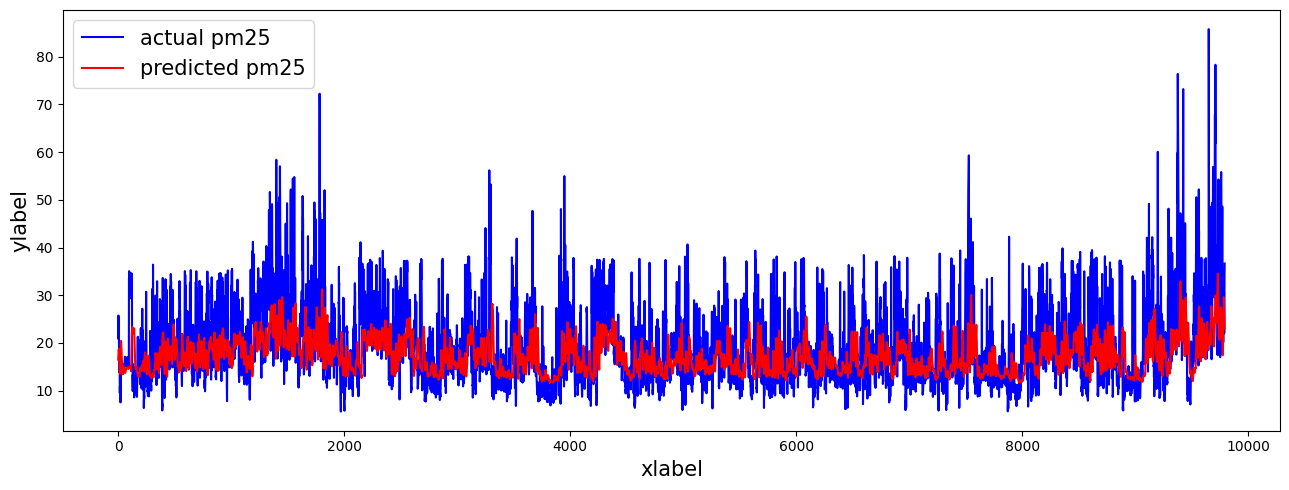

Day = 20
mae: 5.818906065706613
mse: 68.54763678468623
rmse: 8.279350021872867
r2: -2.862131351645548
mape: 0.3700937565647823
mnbe: -15.309490916108459
r_coeff: [0.39089768]


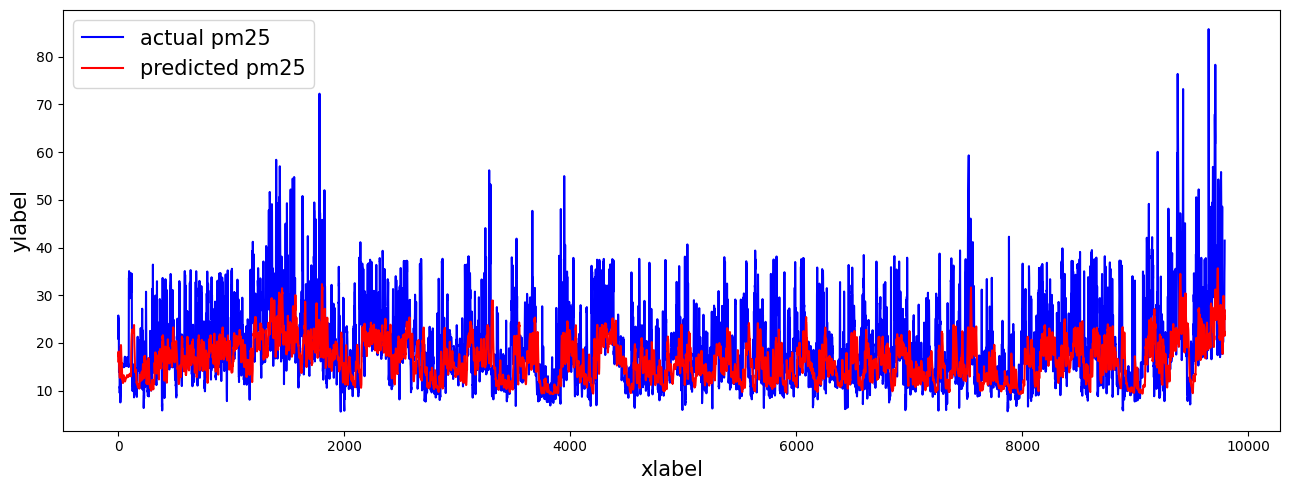

Day = 21
mae: 5.892372971460148
mse: 71.74648118973035
rmse: 8.470329461699253
r2: -4.7215873033546565
mape: 0.3821906549672379
mnbe: -18.28773789728772
r_coeff: [0.38705617]


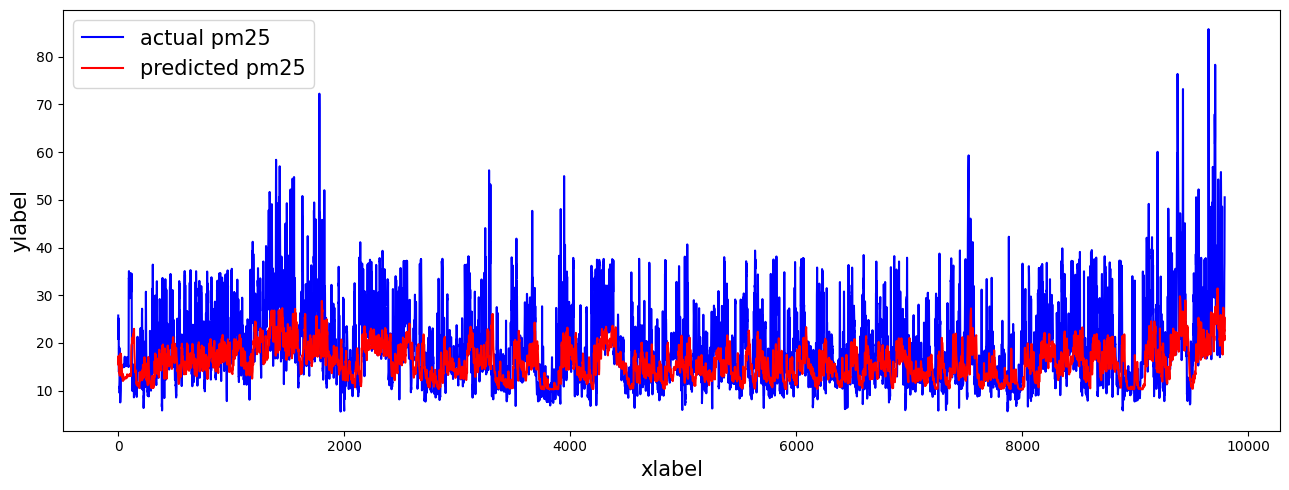

Day = 22
mae: 5.646385825114501
mse: 64.76535420156883
rmse: 8.047692476826436
r2: -5.488674610020055
mape: 0.33154862868577134
mnbe: -11.521792261571484
r_coeff: [0.37767346]


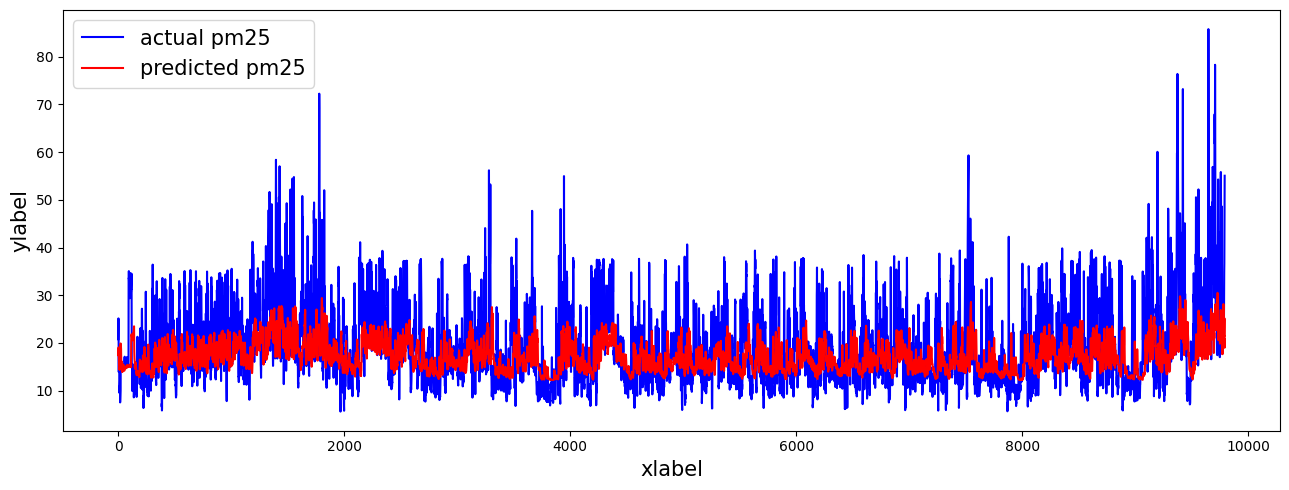

Day = 23
mae: 6.006715683428637
mse: 72.17697482958305
rmse: 8.495703315769862
r2: -2.4802583378297163
mape: 0.3974209847830762
mnbe: -17.18940876810272
r_coeff: [0.38553496]


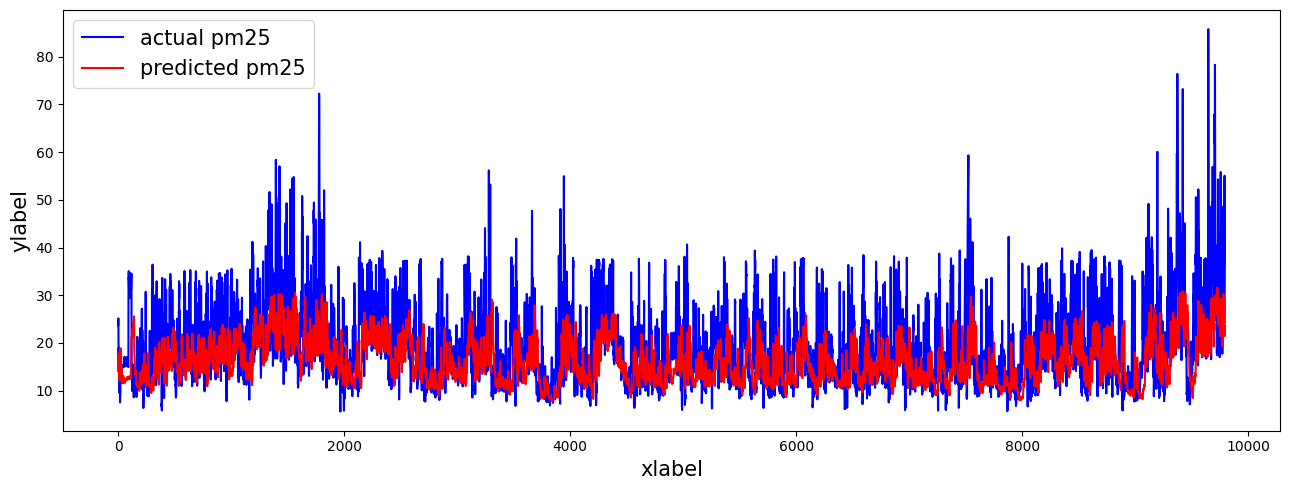

In [12]:
n_future = 24
X_train, y_train, X_test, y_test = X_train_24h, y_train_24h, X_test_24h, y_test_24h

lstms2s_24h = define_lstms2s_model(n_past, n_future, X_train.shape[-1], y_train.shape[-1], f"{label}_lstms2s_{n_future}h")

history = lstms2s_24h.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [reduce_lr_callback, early_stopping_callback],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = lstms2s_24h.predict(X_test)
print(f"y_pred.shape = {y_pred.shape}")

# Save model
lstms2s_24h.save(os.path.join(RESULT_DIR, f"{lstms2s_24h.name}.keras"))

inv_y_pred = np.expand_dims(label_scaler.inverse_transform(y_pred), -1)
inv_y_test = np.expand_dims(label_scaler.inverse_transform(y_test[:, :, 0]), -1)
print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    
    current_day_y_pred, current_day_y_test = inv_y_pred[:, day, :], inv_y_test[:, day, :]
    shifted_inv_y_pred, shifted_inv_y_test = current_day_y_pred[1:], current_day_y_test[:-1]
    
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(shifted_inv_y_pred, shifted_inv_y_test)}")
    plot_2_data(data1=shifted_inv_y_test, datalabel1="actual pm25", data2=shifted_inv_y_pred, datalabel2="predicted pm25")